# Add data to colab

In [1]:
!rm -rf /content/sample_data
!git clone https://github.com/MoritzCermann/semantic-segmentation-camvid.git

# move files into /content
!mv /content/semantic-segmentation-camvid/* /content/
!rm -rf /content/semantic-segmentation-camvid

Cloning into 'semantic-segmentation-camvid'...
remote: Enumerating objects: 1432, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 1432 (delta 5), reused 18 (delta 5), pack-reused 1413
Receiving objects: 100% (1432/1432), 569.63 MiB | 16.84 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (1408/1408), done.


In [2]:
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
model_name = 'unet_miniv2'
input_shape = 256 # height & width

# Load model

In [4]:
path = '/content/drive/MyDrive/ColabNotebooks/' + model_name
model_path = path + '.h5'

model = tf.keras.models.load_model(model_path)

# Load data

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from utils import load_data_from_dir

In [6]:
base_dir = os.getcwd()

# Create dataframe
train_image_df = pd.read_csv(base_dir + '/data/camvid_train.txt', header=None, sep=' ', names=['image', 'mask']) # 367 rows
val_image_df = pd.read_csv(base_dir + '/data/camvid_val.txt', header=None, sep=' ', names=['image', 'mask']) # 101 rows
test_image_df = pd.read_csv(base_dir + '/data/camvid_test.txt', header=None, sep=' ', names=['image', 'mask']) # 233 rows

# Used classes
classes = [
    'Sky', 'Building', 'Pole', 'Road', 'Pavement', 'Tree',
    'SignSymbol', 'Fence', 'Car', 'Pedestrian', 'Bicyclist',
    'Void'
    ]

n_class = 11 # class 'Void' (backgorund) is ignored

In [7]:
# Load data into dataframe
image_dim = (256, 256)
train_images, train_masks = load_data_from_dir(train_image_df, True, image_dim)
val_images, val_masks = load_data_from_dir(val_image_df, True, image_dim)
test_images, test_masks = load_data_from_dir(test_image_df, True, image_dim)

print(train_images.shape)
print(train_masks.shape)
print(val_images.shape)
print(val_masks.shape)
print(test_images.shape)
print(test_masks.shape)

367it [00:12, 29.15it/s]
101it [00:03, 27.01it/s]
233it [00:07, 30.13it/s]


(367, 256, 256, 3)
(367, 256, 256, 1)
(101, 256, 256, 3)
(101, 256, 256, 1)
(233, 256, 256, 3)
(233, 256, 256, 1)


Seq05VD is a sequence of images the model is not trained on

In [8]:
test_df_Seq05VD = test_image_df.loc[test_image_df['image'].str.contains("Seq05VD")]
test_images_Seq05VD, test_masks_Seq05VD = load_data_from_dir(test_df_Seq05VD, True, image_dim)
print(test_df_Seq05VD.shape)
print(test_images_Seq05VD.shape)
print(test_masks_Seq05VD.shape)

171it [00:05, 29.15it/s]


(171, 2)
(171, 256, 256, 3)
(171, 256, 256, 1)


In [11]:
#masks = test_masks_Seq05VD
masks = test_masks

# the percentage distribution of each class in the test masks
unique, counts = np.unique(masks, return_counts=True)
total = sum(counts)

dict(zip(classes, (counts/total).round(3)))

{'Sky': 0.172,
 'Building': 0.246,
 'Pole': 0.012,
 'Road': 0.254,
 'Pavement': 0.095,
 'Tree': 0.113,
 'SignSymbol': 0.01,
 'Fence': 0.012,
 'Car': 0.042,
 'Pedestrian': 0.007,
 'Bicyclist': 0.002,
 'Void': 0.035}

2.2 Show images and masks

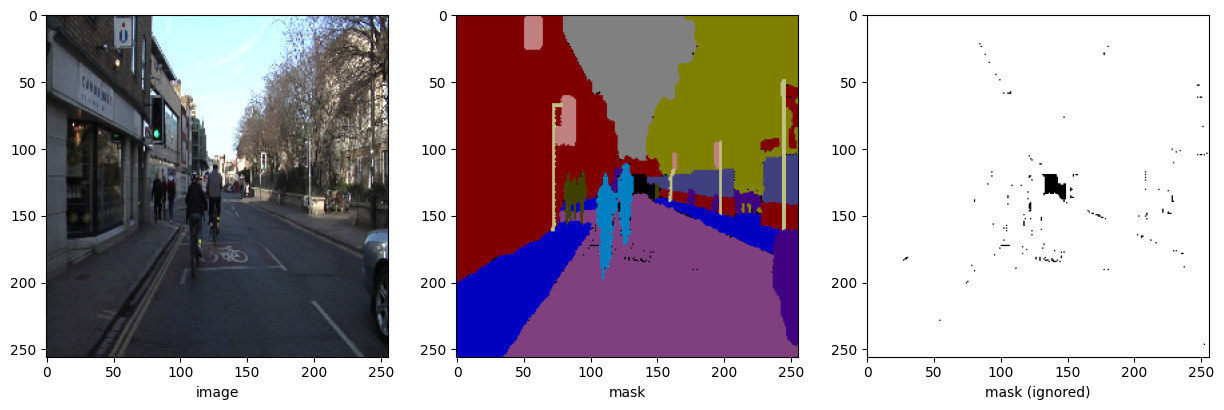

In [12]:
from utils import convert_indexed_to_rgb_mask

i = 50

fig, ax = plt.subplots(1,3, figsize=(15,6))
ax[0].imshow(val_images[i], vmin=0, vmax=1)
ax[0].set_xlabel('image')
ax[1].imshow(convert_indexed_to_rgb_mask(val_masks[i]))
ax[1].set_xlabel('mask')
ax[2].imshow(val_masks[i] == 255, cmap='binary')
ax[2].set_xlabel('mask (ignored)')
plt.show()

-----------------

# Evaluate model

In [13]:
images = test_images
masks = test_masks
#images = test_images_Seq05VD
#masks = test_masks_Seq05VD

In [14]:
model.evaluate(images, masks)

masks_pred = model.predict(images)
masks_pred = np.expand_dims(np.argmax(masks_pred, axis=-1), -1)

# Assign values in void regions to 255
masks_pred[masks == 255] = 255

8/8 [==============================] - 46s 6s/step


## 4.1 Plot predicted masks

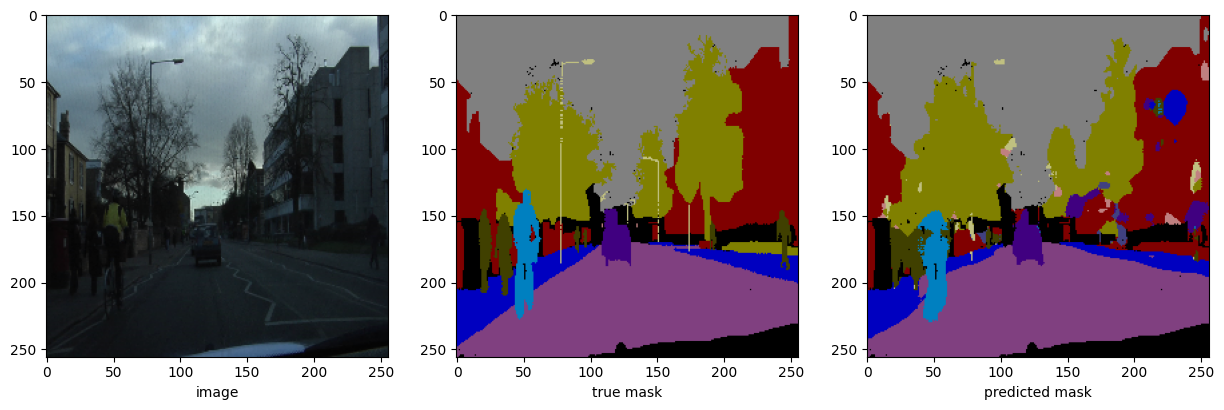

In [20]:
i = 2

fig, ax = plt.subplots(1,3, figsize=(15,6), dpi=100)
ax[0].imshow(images[i], vmin=0, vmax=1)
ax[0].set_xlabel('image')
ax[1].imshow(convert_indexed_to_rgb_mask(masks[i]))
ax[1].set_xlabel('true mask')
ax[2].imshow(convert_indexed_to_rgb_mask(masks_pred[i]))
ax[2].set_xlabel('predicted mask')
plt.show()

#4.2 Evaluate pixel-wise accuracy

In [21]:
from utils import evaluate_pixel_accuracy_by_class, evaluate_pixel_accuracy_global

# Pixel accuracy by class
class_acc = np.zeros(n_class)
for i in range(n_class):
    class_acc[i] = evaluate_pixel_accuracy_by_class(masks, masks_pred, i_class=i)*100

# Global average
global_acc = evaluate_pixel_accuracy_global(masks, masks_pred)*100

print('Pixel-wise accuracy:')
for i in range(n_class):
    print(str(i) + '. ' + classes[i] + ': {:.1f}'.format(class_acc[i]))
print('Class avg: {:.1f}'.format(class_acc[:11].sum()/12))
print('Global avg: {:.1f}'.format(global_acc))

Pixel-wise accuracy:
0. Sky: 96.4
1. Building: 80.1
2. Pole: 12.4
3. Road: 96.2
4. Pavement: 78.1
5. Tree: 70.3
6. SignSymbol: 27.0
7. Fence: 10.7
8. Car: 68.7
9. Pedestrian: 37.0
10. Bicyclist: 23.0
Class avg: 50.0
Global avg: 82.7


4.3 Evaluate intersection-over-union (IOU or Jaccard score)

In [22]:
from utils import evaluate_jaccard_score_by_class

iou = np.zeros(n_class)
for i in range(n_class):
    iou[i] = evaluate_jaccard_score_by_class(masks, masks_pred, i_class=i)

print('Test set IOU by class:')
for i in range(n_class):
    print(classes[i] + ': ' + str(iou[i].round(2)))
print('11-category mIOU:' + str(iou[:11].mean().round(2)))

Test set IOU by class:
Sky: 0.89
Building: 0.68
Pole: 0.09
Road: 0.88
Pavement: 0.66
Tree: 0.57
SignSymbol: 0.12
Fence: 0.06
Car: 0.57
Pedestrian: 0.2
Bicyclist: 0.17
11-category mIOU:0.44


In [ ]:
from utils import convert_indexed_to_rgb_masks
import imageio
!pip install opencv-python
import cv2

masks_pred_rgb = convert_indexed_to_rgb_masks(masks_pred)
masks_rgb = convert_indexed_to_rgb_masks(masks)
images_uint8 = (images*255).astype('uint8')

imgs = np.concatenate([images_uint8,
                cv2.addWeighted(images_uint8, 0.5, masks_rgb, 0.5, 0),
                cv2.addWeighted(images_uint8, 0.5, masks_pred_rgb, 0.5, 0)], axis=2)

filename = 'animation.gif'
imageio.mimsave(filename, imgs, fps=7)